In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
# Load the data
df = pd.read_csv('MaunaLoaDailyTemps.csv', index_col='DATE', parse_dates=True).dropna()
df.head()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


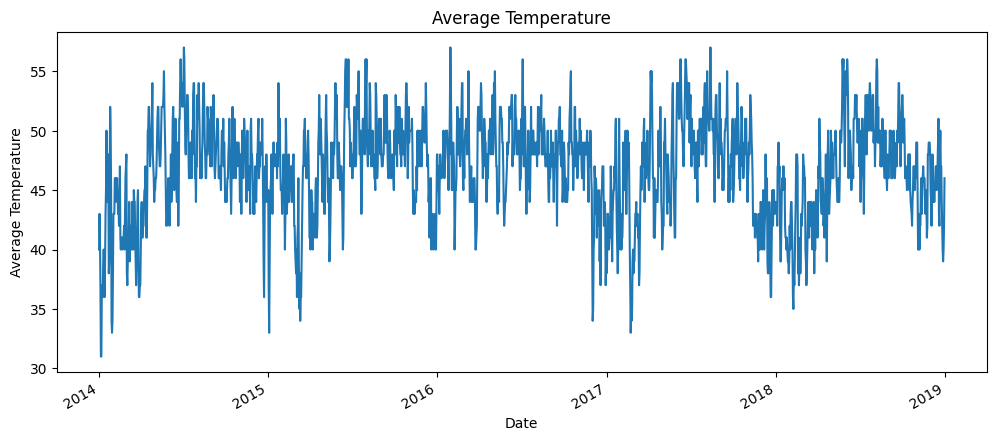

In [5]:
df['AvgTemp'].plot(figsize=(12, 5))
plt.title('Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.show()

In [6]:
# Preprocess the data
data = df['AvgTemp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [7]:
# Define sequence length
sequence_length = 30

In [8]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, 0])
    y.append(data_scaled[i+sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #(number of samples, sequence length=30, number of features=1)
X.shape

(1791, 30, 1)

In [9]:
# Split the dataset into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X.shape[1], X.shape[2]), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50

41/41 [==============================] - 2s 14ms/step - loss: 0.1986 - val_loss: 0.0225
Epoch 2/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0189 - val_loss: 0.0131
Epoch 3/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0129
Epoch 4/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0130
Epoch 5/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0122
Epoch 6/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0132
Epoch 7/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0122
Epoch 8/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 9/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0108
Epoch 10/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0110
Epoch 11/50
41/41

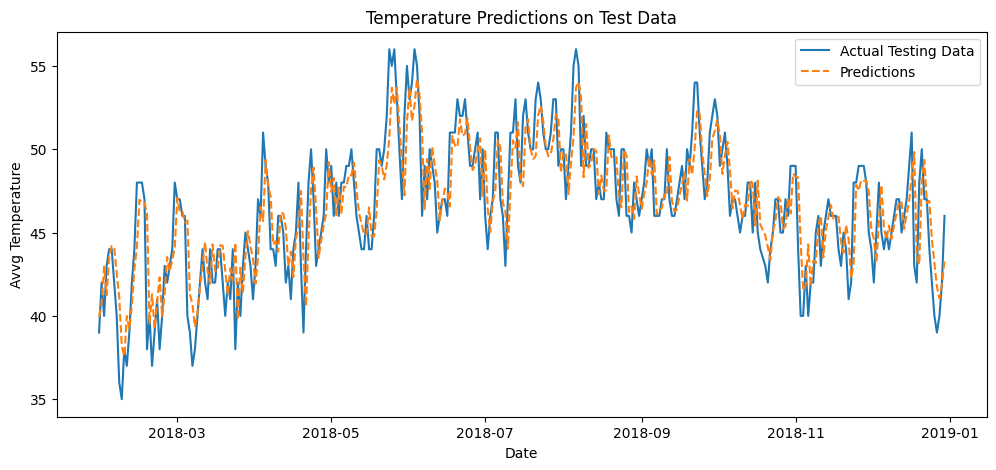

In [15]:
# Plotting predictions vs. actual
plt.figure(figsize=(12, 5))
plt.plot(df.index[split+sequence_length:], df['AvgTemp'][split+sequence_length:], label='Actual Testing Data')
plt.plot(df.index[split+sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Avvg Temperature')
plt.legend()
plt.show()

In [16]:
# Calculating RMSE for test predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

test_actual_temps = df['AvgTemp'][split + sequence_length:].values
test_mse = mean_squared_error(test_actual_temps, test_predictions)
test_rmse = sqrt(test_mse)

print(f"Root Mean Squared Error (RMSE) on Test Data: {test_rmse}")


Root Mean Squared Error (RMSE) on Test Data: 2.2019658859964


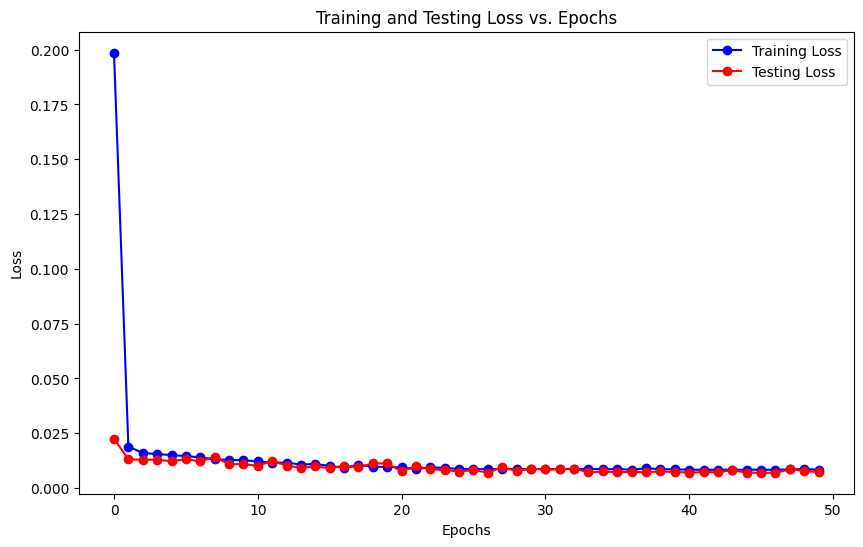

In [17]:
# Plotting Training and Testing Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
